import necessary libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn 
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score,precision_score,recall_score
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import validation_curve,learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from tensorflow import keras as ks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


load the data and impute missing data using KNNImputer

In [323]:
df=pd.read_csv('final v3.csv')
df.drop('IMDB ID',inplace=True,axis=1)
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=5,weights='distance')
df=pd.DataFrame(imp.fit_transform(df),index=df.index , columns=df.columns)

check how our data look like

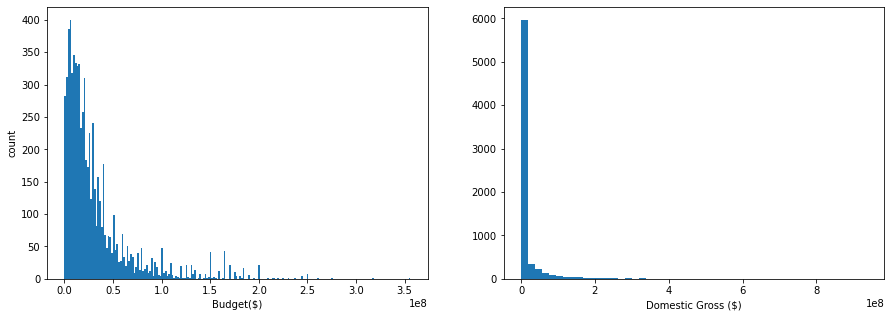

In [324]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].hist(df['Budget'],bins=200)
ax[0].set_xlabel('Budget($)')
ax[1].hist(df['Domestic Gross ($)'],bins=50)
ax[1].set_xlabel('Domestic Gross ($)')

ax[0].set_ylabel('count')
plt.show()

In [325]:
df.head()

,Mojo ID,Year,Opening ($),Budget,Opening Theaters,In Realease (Days),Widest Release,Running time (min),IMDB score,IMDB votes,...,Writer(s) rank,Stars rank,Distributor rank,additive Producer(s) rank,additive Director(s) rank,additive Writer(s) rank,additive Stars rank,additive Distributor rank,Domestic Gross ($),Worldwide Gross ($)
0,8.769715e+08,2011.0,77025481.0,237000000.0,3452.0,379.0,3461.0,162.0,7.8,1122762.0,...,0.0,1.0,1.0,78817892.4,8757543.6,8757543.6,43787718.0,8757543.6,749766139.0,2.744337e+09
1,1.383565e+09,2011.0,110307189.0,200000000.0,4028.0,203.0,4028.0,103.0,8.2,760723.0,...,0.0,1.0,1.0,24951714.4,6237928.6,43665500.2,37427571.6,6237928.6,415004880.0,1.066970e+09
2,3.393226e+09,2011.0,116101023.0,200000000.0,3728.0,302.0,3739.0,108.0,6.4,385498.0,...,0.0,0.0,0.0,24671872.0,2467187.2,4934374.4,14803123.2,2467187.2,334191110.0,1.025467e+09
3,1.515882e+09,2011.0,128122480.0,200000000.0,4380.0,239.0,4390.0,124.0,7.0,726620.0,...,0.0,1.0,1.0,61036080.0,5086340.0,25431700.0,30518040.0,5086340.0,312433331.0,6.239333e+08
4,6.596541e+08,2011.0,64832191.0,68000000.0,4468.0,185.0,4468.0,124.0,5.0,229133.0,...,0.0,0.0,0.0,10310985.0,1145665.0,2291330.0,6873990.0,1145665.0,300531751.0,6.984913e+08


In [326]:
df.isnull().values.any()

False

## classification problem (on Worldwide Gross)

In [327]:
df=df.drop(['additive Producer(s) rank',
'additive Director(s) rank',
'additive Writer(s) rank',
'additive Stars rank',
'additive Distributor rank','IMDB score','IMDB votes',
'Mojo ID','Opening ($)','In Realease (Days)',
'Widest Release','Metascore','User',
'Critic','Year'],axis=1)


X=df.drop(['Domestic Gross ($)','Worldwide Gross ($)'],axis=1).to_numpy()
Y=df['Domestic Gross ($)'].to_numpy()
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X,Y=shuffle(X,Y)


In [328]:
df

,Budget,Opening Theaters,Running time (min),genre Action,genre Adventure,genre Fantasy,genre Sci-Fi,genre Animation,genre Comedy,genre Family,...,country Swaziland,country Republic of North Macedonia,country Reunion,Producer(s) rank,Director(s) rank,Writer(s) rank,Stars rank,Distributor rank,Domestic Gross ($),Worldwide Gross ($)
0,2.370000e+08,3452.0,162.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,749766139.0,2.744337e+09
1,2.000000e+08,4028.0,103.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,415004880.0,1.066970e+09
2,2.000000e+08,3728.0,108.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334191110.0,1.025467e+09
3,2.000000e+08,4380.0,124.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,312433331.0,6.239333e+08
4,6.800000e+07,4468.0,124.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300531751.0,6.984913e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7091,5.591229e+07,1.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1273.0,1.273000e+03
7092,5.134240e+07,1.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4140.0,4.140000e+03
7093,2.970658e+07,1.0,104.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,790.0,7.900000e+02
7094,8.025029e+06,1.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1737.0,7.086596e+06


make different classes based on the revenue of the movies. below you see the two ways that we can classify the movies. The first one (below) is the more accurate one but due to the lack of enough movies for each class we choose the second method for our problem. 

In [329]:
dic_classification={}

dic_classification['super hit']=df.loc[(df['Budget']>50e6) & (df['Budget']*4<=df['Worldwide Gross ($)'])].index

dic_classification['blockbuster']=df.loc[(df['Budget']>50e6) & (df['Budget']*4>df['Worldwide Gross ($)']) & (df['Budget']*2.5<=df['Worldwide Gross ($)'])].index

dic_classification['minor success']=df.loc[(df['Budget']>50e6) & (df['Budget']*2.5>df['Worldwide Gross ($)']) & (df['Budget']*1.5<=df['Worldwide Gross ($)'])].index

dic_classification['flop']=df.loc[(df['Budget']>50e6) & (df['Budget']*1.5>df['Worldwide Gross ($)']) & (df['Budget']<=df['Worldwide Gross ($)'])].index

dic_classification['box office bomb'] = df.loc[(df['Budget']>50e6) & (df['Budget']>df['Worldwide Gross ($)'])].index

dic_classification['hit'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*2<=df['Worldwide Gross ($)'])].index

dic_classification['minor success for mid budget'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*2>df['Worldwide Gross ($)']) & (df['Budget']*1<=df['Worldwide Gross ($)'])].index

dic_classification['failure'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*1>df['Worldwide Gross ($)'])].index

dic_classification['great success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2<=df['Worldwide Gross ($)'])].index

#dic_classification['big success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2>df['Worldwide Gross ($)']) & (df['Budget']<=df['Worldwide Gross ($)'])].index

#dic_classification['success'] = df.loc[(df['Budget']<=1e6)  &  (df['Budget']>df['Worldwide Gross ($)'])].index

dic_classification['success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2>df['Worldwide Gross ($)']) ].index


In [330]:
#df=df.reset_index()
dic_classification={}

dic_classification['blockbuster']=df.loc[(df['Budget']>50e6) & (df['Budget']*2.5<=df['Worldwide Gross ($)'])].index

#dic_classification['blockbuster']=df.loc[(df['Budget']>50e6) & (df['Budget']*4>df['Worldwide Gross ($)']) & (df['Budget']*2.5<=df['Worldwide Gross ($)'])].index

dic_classification['minor success']=df.loc[(df['Budget']>50e6) & (df['Budget']*2.5>df['Worldwide Gross ($)']) & (df['Budget']*1<=df['Worldwide Gross ($)'])].index

dic_classification['flop']=df.loc[(df['Budget']>50e6) & (df['Budget']*1>df['Worldwide Gross ($)']) ].index

#dic_classification['box office bomb'] = df.loc[(df['Budget']>50e6) & (df['Budget']>df['Worldwide Gross ($)'])].index

dic_classification['hit'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*1<=df['Worldwide Gross ($)'])].index

dic_classification['terrible'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*1>df['Worldwide Gross ($)']) & (df['Budget']*0.1<=df['Worldwide Gross ($)'])].index

dic_classification['failure'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*0.1>df['Worldwide Gross ($)'])].index

dic_classification['great success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2<=df['Worldwide Gross ($)'])].index

#dic_classification['big success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2>df['Worldwide Gross ($)']) & (df['Budget']<=df['Worldwide Gross ($)'])].index

#dic_classification['success'] = df.loc[(df['Budget']<=1e6)  &  (df['Budget']>df['Worldwide Gross ($)'])].index

dic_classification['success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2>df['Worldwide Gross ($)']) ].index


This is how our classification looks like:

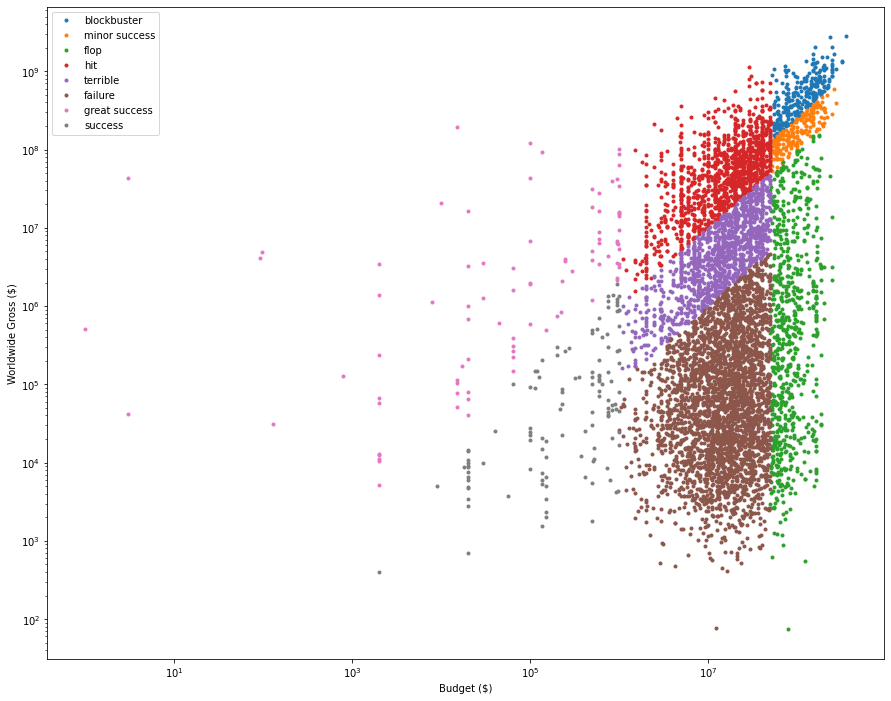

In [331]:
plt.figure(figsize=(15,12))
for key in dic_classification.keys():
    plt.plot(df.loc[dic_classification[key]]['Budget'],df.loc[dic_classification[key]]['Worldwide Gross ($)'],'.',label=key)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Budget ($)')
plt.ylabel('Worldwide Gross ($)')
plt.show()

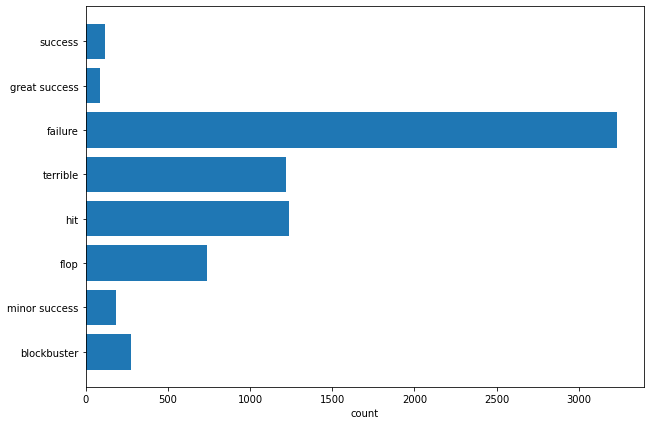

In [332]:
plt.figure(figsize=(10,7))
heights=[len(dic_classification[key]) for key in dic_classification.keys()]
plt.barh(list(dic_classification.keys()),heights)
plt.xlabel('count')
plt.show()

In [333]:
v=0
for key in dic_classification.keys():
    print(key,len(dic_classification[key]))
    v+=len(dic_classification[key])
print(v)

blockbuster 275
minor success 188
flop 737
hit 1238
terrible 1217
failure 3232
great success 89
success 120
7096


In [334]:
label={key:i for i,key in enumerate(dic_classification.keys())}
for key in dic_classification.keys():
    df.loc[dic_classification[key],'class'] = int(label[key])

In [335]:
label

{'blockbuster': 0,
 'minor success': 1,
 'flop': 2,
 'hit': 3,
 'terrible': 4,
 'failure': 5,
 'great success': 6,
 'success': 7}

In [336]:
X=df.drop(['Domestic Gross ($)','Worldwide Gross ($)','class'],axis=1).to_numpy()
Y=df['class'].to_numpy()
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X,Y=shuffle(X,Y)

In [337]:
print(f'X: {X.shape} \nY: {Y.shape}')

X: (7096, 275) 
Y: (7096,)


In [338]:
Y_oh = ks.utils.to_categorical(Y, num_classes=len(set(Y)), dtype=int)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)

In [339]:
import kerastuner as kt

def model_builder(hp):
    model = Sequential()
    #model.add(ks.layers.Flatten(input_shape=(1,11)))

    hp_units = hp.Int('units1', min_value=5, max_value=100, step=5)
    model.add(ks.layers.Dense(units=hp_units, input_dim=np.shape(X)[1],
                               activation='relu', 
                               kernel_regularizer=ks.regularizers.l2(.05)))

    
    hp_units2 = hp.Int('units2', min_value=5, max_value=100, step=5)
    model.add(Dense(units=hp_units2, activation='tanh',kernel_regularizer=ks.regularizers.l2(.05)))
    model.add(Dense(len(set(Y)), activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=ks.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [340]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=os.path.normpath('C:/'),
                     project_name='nn_class_v3')

INFO:tensorflow:Reloading Oracle from existing project C:\nn_class_v3\oracle.json
INFO:tensorflow:Reloading Tuner from C:\nn_class_v3\tuner0.json


In [341]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [342]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and for second layers is {best_hps.get('units2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 35 and for second layers is 75 and the optimal learning rate for the optimizer
is 0.01.



In [482]:
def model_fn():
    model = ks.Sequential([
    #keras.layers.Flatten(input_shape=(32, 32)),    
    ks.layers.Dense(35,activation=tf.nn.relu, kernel_regularizer=ks.regularizers.l2(0.05) ),
    ks.layers.Dense(75,activation=tf.nn.tanh, kernel_regularizer=ks.regularizers.l2(0.05)),
    ks.layers.Dense(len(set(Y)), activation=tf.nn.softmax)
        ])
    model.compile(loss= 'sparse_categorical_crossentropy', optimizer=ks.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

    return model

In [486]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

csv_logger = CSVLogger('training-class-world.log', append=True)
calls=[csv_logger, EarlyStopping(monitor='loss', patience=10)]

ks_model = KerasClassifier(build_fn=model_fn, epochs=250, batch_size=500, verbose=0  )
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0 )
results = cross_val_score(ks_model, X, np.argmax(Y_oh,axis=1).reshape(-1,1), cv=kfold,fit_params = {'callbacks': calls})

In [487]:
df2 = pd.read_csv('training-class-world.log')
df2

,epoch,accuracy,loss
0,0,0.434075,3.880243
1,1,0.477137,1.746446
2,2,0.525211,1.518675
3,3,0.541184,1.426289
4,4,0.551676,1.391737
...,...,...,...
1418,76,0.575544,1.226114
1419,77,0.577579,1.216199
1420,78,0.575544,1.222460
1421,79,0.578049,1.220815


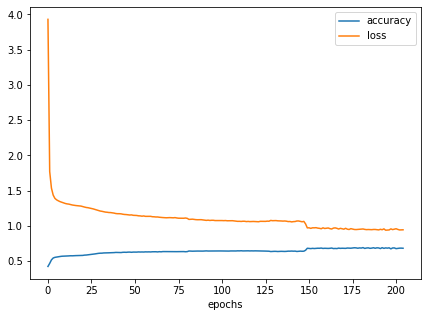

In [498]:
plt.figure(figsize=(7,5))
plt.plot(df2.groupby('epoch').mean())
plt.legend(['accuracy','loss'])
plt.xlabel('epochs')
plt.savefig('cross-val-class-world.pdf',bbox_inches='tight')

In [490]:
max(df2.groupby('epoch')['accuracy'].mean())

0.6895256042480469

In [491]:
%%time
model = model_fn()
history = model.fit(X_train,np.argmax(Y_train,axis =1).reshape(-1,1),epochs=250,batch_size=500,validation_split=0.2,verbose=1)

Epoch 1/250
9/9 [==============================] - 1s 24ms/step - loss: 5.9215 - accuracy: 0.3178 - val_loss: 2.4799 - val_accuracy: 0.4516
Epoch 2/250
9/9 [==============================] - 0s 5ms/step - loss: 2.2218 - accuracy: 0.4491 - val_loss: 1.7766 - val_accuracy: 0.4516
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 1.7691 - accuracy: 0.4520 - val_loss: 1.5968 - val_accuracy: 0.4676
Epoch 4/250
9/9 [==============================] - 0s 4ms/step - loss: 1.5856 - accuracy: 0.4900 - val_loss: 1.4717 - val_accuracy: 0.5211
Epoch 5/250
9/9 [==============================] - 0s 4ms/step - loss: 1.4912 - accuracy: 0.5228 - val_loss: 1.4402 - val_accuracy: 0.5671
Epoch 6/250
9/9 [==============================] - 0s 5ms/step - loss: 1.4348 - accuracy: 0.5442 - val_loss: 1.3754 - val_accuracy: 0.5474
Epoch 7/250
9/9 [==============================] - 0s 5ms/step - loss: 1.4041 - accuracy: 0.5399 - val_loss: 1.3552 - val_accuracy: 0.5559
Epoch 8/250
9/9 [=========

Text(0.5, 0, 'epochs')

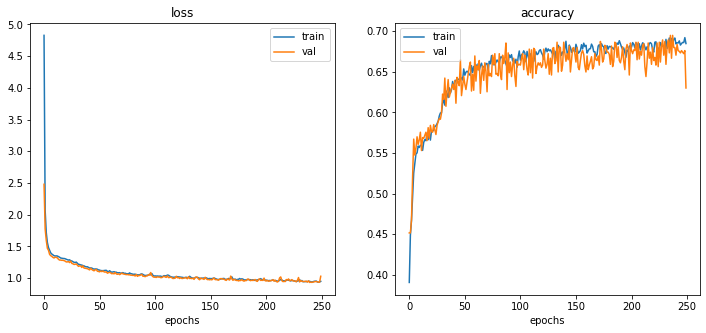

In [492]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])

ax[0].legend(['train','val'])
ax[1].legend(['train','val'])

ax[0].set_title('loss')
ax[1].set_title('accuracy')

ax[0].set_xlabel('epochs')
ax[1].set_xlabel('epochs')

In [493]:
model.summary()

Model: "sequential_193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_589 (Dense)            (None, 35)                9660      
_________________________________________________________________
dense_590 (Dense)            (None, 75)                2700      
_________________________________________________________________
dense_591 (Dense)            (None, 8)                 608       
Total params: 12,968
Trainable params: 12,968
Non-trainable params: 0
_________________________________________________________________


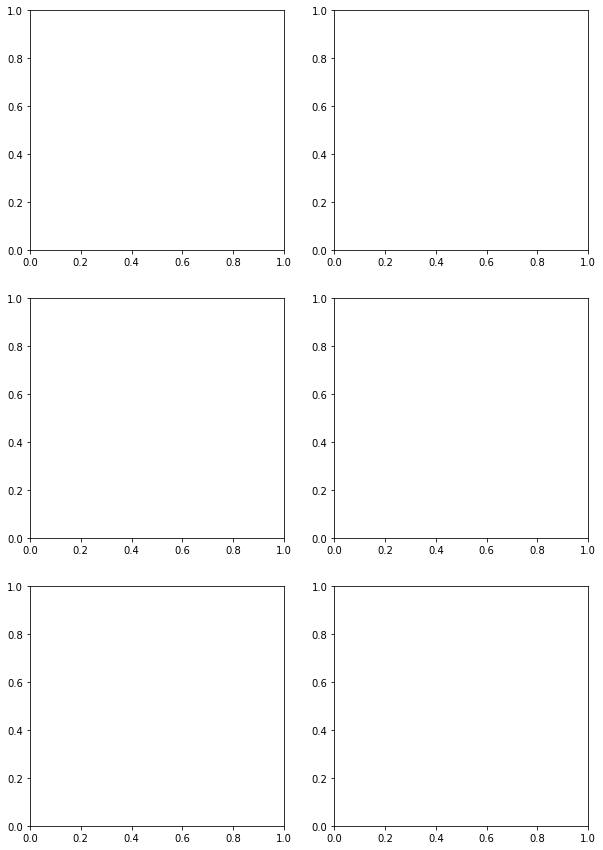

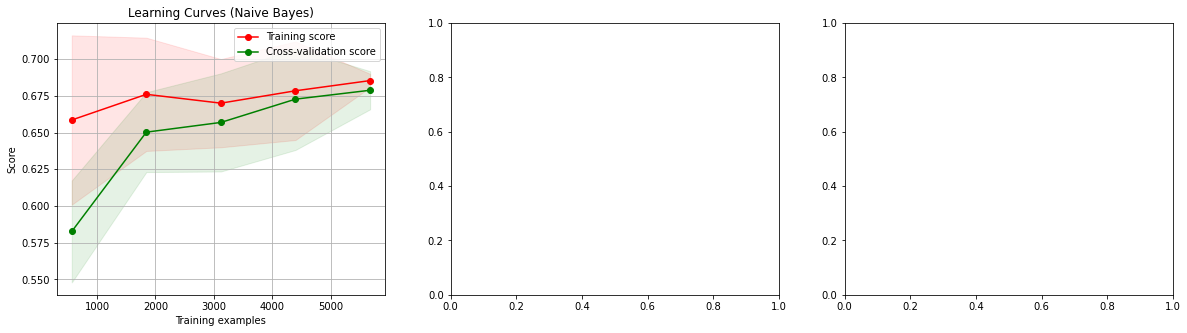

In [514]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt






title = "Learning Curves"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

plot_learning_curve(ks_model, title, X, np.argmax(Y_oh,axis=1).reshape(-1,1),cv=cv)
plt.savefig('learning-curves-class-world.pdf',bbox_inches='tight')
plt.show()

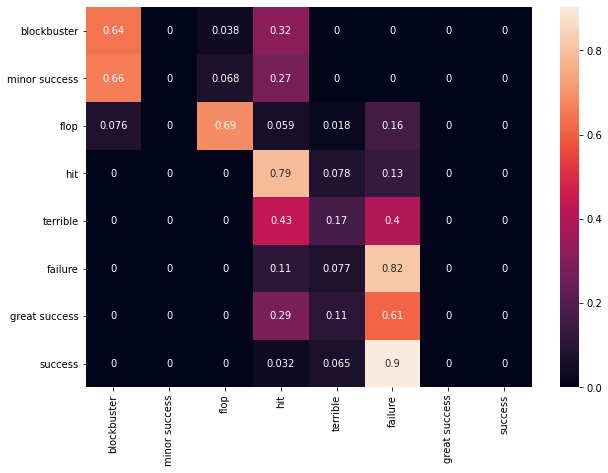

In [502]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(np.argmax( Y_test , axis=1 ), Y_predicted,normalize='true')
#vector = cm.sum(axis=1)

#cm = cm / vector[:,None]
df_cm = pd.DataFrame(cm, index = [key for key in dic_classification.keys()],
                  columns = [key for key in dic_classification.keys()])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
#plt.savefig('confusion-world.pdf',bbox_inches='tight')
plt.show()

<AxesSubplot:>

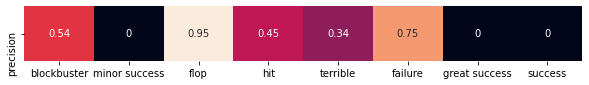

In [497]:
y_pred=np.argmax( model.predict(X_test) , axis=1 )

prec = precision_score(np.argmax(Y_test,axis=1),y_pred,average= None,zero_division=False)
df_cm = pd.DataFrame(prec.reshape(1,-1), columns = [key for key in dic_classification.keys()],
                  index = ['precision'])
plt.figure(figsize = (10,1))
plt.savefig('precision-world.pdf',bbox_inches = 'tight')
sns.heatmap(df_cm, annot=True,cbar=0)

In [509]:
precision_score(np.argmax(Y_test,axis=1),y_pred,average= 'weighted',zero_division=False)

0.6014843424496814

## classification problem (on domestic Gross)

In this section we try to solve a slightly different classification problem from the previous section. Here we want to classify the movies based on their domestic Gross. For this end, we propose a different classification scheme that only depends on the domestic gross and not the budget of the movie. We devide the gross range to five section exponentialy. 

In [138]:
df=pd.read_csv('final v3.csv')
df.drop('IMDB ID',inplace=True,axis=1)
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=5,weights='distance')
df=pd.DataFrame(imp.fit_transform(df),index=df.index , columns=df.columns)

df=df.drop(['additive Producer(s) rank',
'additive Director(s) rank',
'additive Writer(s) rank',
'additive Stars rank',
'additive Distributor rank','IMDB score','IMDB votes',
'Mojo ID','Opening ($)','In Realease (Days)',
'Widest Release','Metascore','User',
'Critic','Year'],axis=1)


X=df.drop(['Domestic Gross ($)','Worldwide Gross ($)'],axis=1).to_numpy()
Y=df['Domestic Gross ($)'].to_numpy()
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X,Y=shuffle(X,Y)


<AxesSubplot:ylabel='Frequency'>

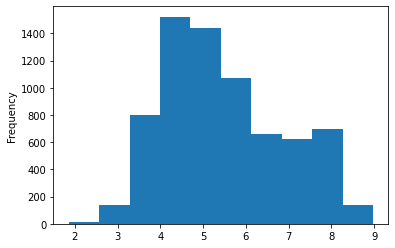

In [139]:
Y_log=np.log10(df['Domestic Gross ($)'])
Y_log.plot(kind='hist')

In [140]:
classess = np.linspace(min(Y_log)-1,max(Y_log)+1,6)

In [141]:
dic_classification={}

dic_classification['very high']=df.loc[ (np.log10(df['Domestic Gross ($)'])<classess[5]) & (np.log10(df['Domestic Gross ($)'])>classess[4])].index

dic_classification['high']=df.loc[ (np.log10(df['Domestic Gross ($)'])<classess[4]) & (np.log10(df['Domestic Gross ($)'])>classess[3])].index

dic_classification['medium']=df.loc[ (np.log10(df['Domestic Gross ($)'])<classess[3]) & (np.log10(df['Domestic Gross ($)'])>classess[2])].index

dic_classification['low']=df.loc[ (np.log10(df['Domestic Gross ($)'])<classess[2]) & (np.log10(df['Domestic Gross ($)'])>classess[1])].index

dic_classification['very low']=df.loc[ (np.log10(df['Domestic Gross ($)'])<classess[1]) & (np.log10(df['Domestic Gross ($)'])>classess[0])].index

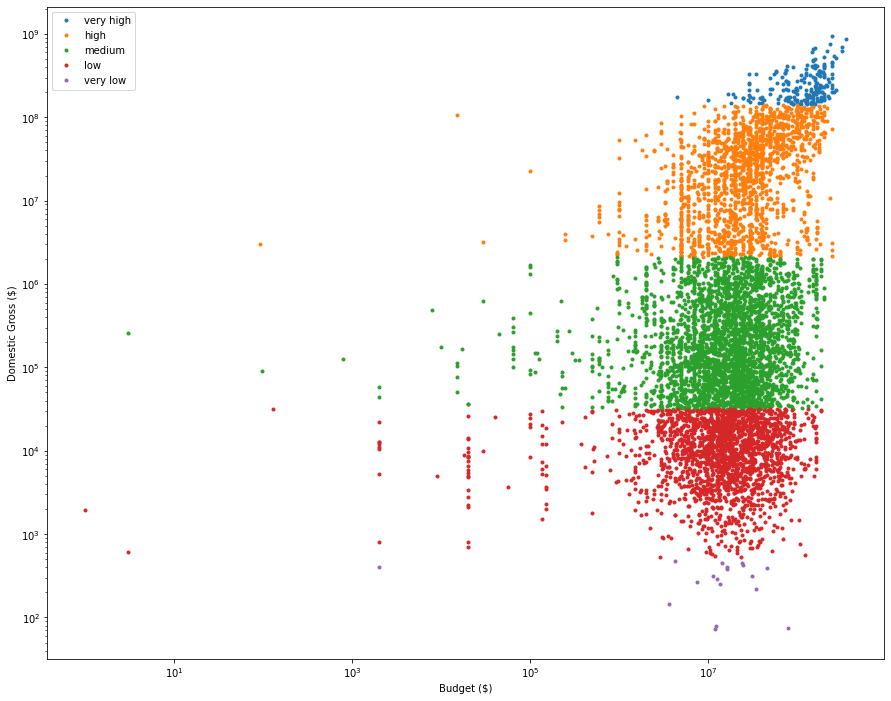

In [142]:
plt.figure(figsize=(15,12))
for key in dic_classification.keys():
    plt.plot(df.loc[dic_classification[key]]['Budget'],df.loc[dic_classification[key]]['Domestic Gross ($)'],'.',label=key)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Budget ($)')
plt.ylabel('Domestic Gross ($)')
plt.show()

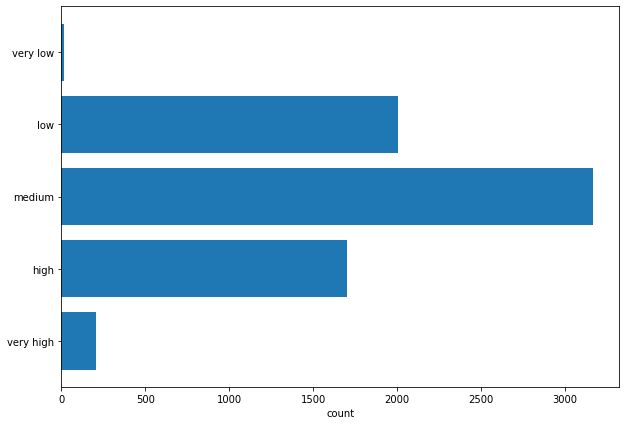

In [143]:
plt.figure(figsize=(10,7))
heights=[len(dic_classification[key]) for key in dic_classification.keys()]
plt.barh(list(dic_classification.keys()),heights)
plt.xlabel('count')
plt.show()

In [144]:
v=0
for key in dic_classification.keys():
    print(key,len(dic_classification[key]))
    v+=len(dic_classification[key])
print(v)

very high 206
high 1702
medium 3166
low 2004
very low 18
7096


In [145]:
label={key:i for i,key in enumerate(dic_classification.keys())}
for key in dic_classification.keys():
    df.loc[dic_classification[key],'class'] = int(label[key])

In [146]:
X=df.drop(['Domestic Gross ($)','Worldwide Gross ($)','class'],axis=1).to_numpy()
Y=df['class'].to_numpy()
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X,Y=shuffle(X,Y)

In [147]:
print(f'X: {X.shape} \nY: {Y.shape}')

X: (7096, 275) 
Y: (7096,)


In [148]:
Y_oh = ks.utils.to_categorical(Y, num_classes=len(set(Y)), dtype=int)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)

In [149]:
import kerastuner as kt

def model_builder(hp):
    model = Sequential()
    #model.add(ks.layers.Flatten(input_shape=(1,11)))

    hp_units = hp.Int('units1', min_value=5, max_value=100, step=5)
    model.add(ks.layers.Dense(units=hp_units, input_dim=np.shape(X)[1],
                               activation='relu', 
                               kernel_regularizer=ks.regularizers.l2(.05)))

    
    hp_units2 = hp.Int('units2', min_value=5, max_value=100, step=5)
    model.add(Dense(units=hp_units2, activation='tanh',kernel_regularizer=ks.regularizers.l2(.05)))
    model.add(Dense(len(set(Y)), activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=ks.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [150]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=os.path.normpath('C:/'),
                     project_name='nn_class_v3_gross_based')

In [151]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [152]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and for second layers is {best_hps.get('units2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.5352112650871277

Best val_accuracy So Far: 0.608450710773468
Total elapsed time: 00h 01m 18s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 40 and for second layers is 70 and the optimal learning rate for the optimizer
is 0.01.



In [153]:
%%time
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=200, validation_split=0.2,verbose=0)



Wall time: 32.6 s


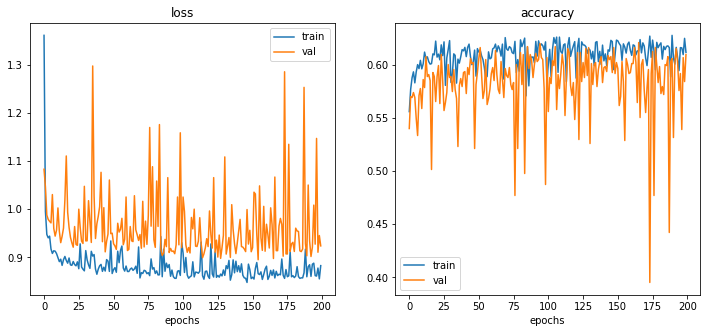

In [154]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])

ax[0].legend(['train','val'])
ax[1].legend(['train','val'])

ax[0].set_title('loss')
ax[1].set_title('accuracy')

ax[0].set_xlabel('epochs')
ax[1].set_xlabel('epochs')
#plt.savefig('val-acc-world.pdf')
plt.show()

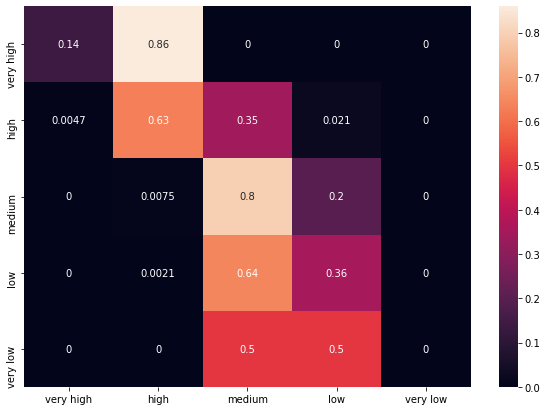

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(np.argmax( Y_test , axis=1 ), Y_predicted)
vector = cm.sum(axis=1)

cm = cm / vector[:,None]
df_cm = pd.DataFrame(cm, index = [key for key in dic_classification.keys()],
                  columns = [key for key in dic_classification.keys()])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()

<AxesSubplot:>

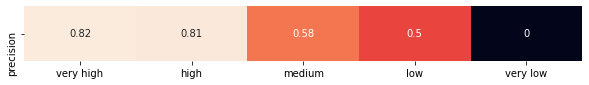

In [156]:
y_pred=np.argmax( model.predict(X_test) , axis=1 )

prec = precision_score(np.argmax(Y_test,axis=1),y_pred,average= None,zero_division=False)
df_cm = pd.DataFrame(prec.reshape(1,-1), columns = [key for key in dic_classification.keys()],
                  index = ['precision'])
plt.figure(figsize = (10,1))
sns.heatmap(df_cm, annot=True,cbar=0)

## early prediction classification on domestic gross 

In this part we want to examine the early prediction classification problem. By early, we mean that despite the previous two sections, here we considereded opennig gross of movies as one the features. 

In [285]:
df=pd.read_csv('final v3.csv')
df.drop('IMDB ID',inplace=True,axis=1)
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=5,weights='distance')
df=pd.DataFrame(imp.fit_transform(df),index=df.index , columns=df.columns)

df=df.drop(['additive Producer(s) rank',
'additive Director(s) rank',
'additive Writer(s) rank',
'additive Stars rank',
'additive Distributor rank','IMDB score','IMDB votes',
'Mojo ID','In Realease (Days)',
'Widest Release','Metascore','User',
'Critic','Year'],axis=1)


X=df.drop(['Domestic Gross ($)','Worldwide Gross ($)'],axis=1).to_numpy()
Y=df['Domestic Gross ($)'].to_numpy()
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X,Y=shuffle(X,Y)


In [286]:
label={key:i for i,key in enumerate(dic_classification.keys())}
for key in dic_classification.keys():
    df.loc[dic_classification[key],'class'] = int(label[key])

In [287]:
X=df.drop(['Domestic Gross ($)','Worldwide Gross ($)','class'],axis=1).to_numpy()
Y=df['class'].to_numpy()
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X,Y=shuffle(X,Y)

In [288]:
print(f'X: {X.shape} \nY: {Y.shape}')

X: (7096, 276) 
Y: (7096,)


In [289]:
Y_oh = ks.utils.to_categorical(Y, num_classes=len(set(Y)), dtype=int)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)

In [ ]:
base line model: 

In [318]:
model = Sequential()
model.add(ks.layers.Dense(20, input_dim=np.shape(X)[1],activation='tanh', kernel_regularizer=ks.regularizers.l2(.05)))
model.add(Dense(units=16, activation='relu',kernel_regularizer=ks.regularizers.l2(.05)))
model.add(Dense(units=5, activation='relu',kernel_regularizer=ks.regularizers.l2(.05)))
model.add(Dense(len(set(Y)), activation='softmax'))
model.summary()
model.compile(optimizer=ks.optimizers.Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 20)                5540      
_________________________________________________________________
dense_27 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 85        
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 30        
Total params: 5,991
Trainable params: 5,991
Non-trainable params: 0
_________________________________________________________________


In [321]:
%%time
history = model.fit(X_train, Y_train, epochs=250, batch_size=50,  verbose=0, validation_split=0.2)

Wall time: 23.1 s


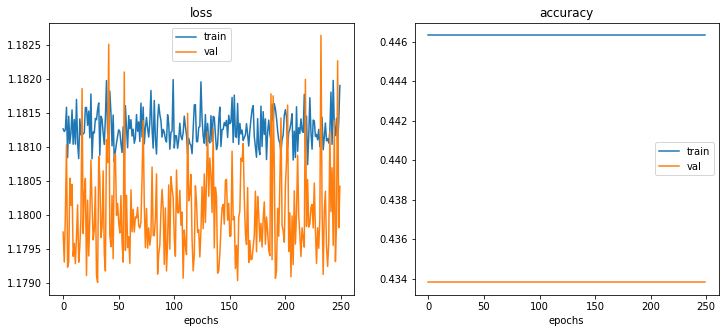

In [322]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])

ax[0].legend(['train','val'])
ax[1].legend(['train','val'])

ax[0].set_title('loss')
ax[1].set_title('accuracy')

ax[0].set_xlabel('epochs')
ax[1].set_xlabel('epochs')
#plt.savefig('val-acc-world-early.pdf')
plt.show()

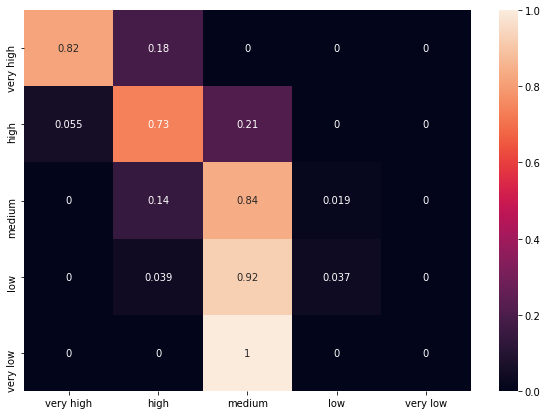

In [313]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(np.argmax( Y_test , axis=1 ), Y_predicted)
vector = cm.sum(axis=1)

cm = cm / vector[:,None]
df_cm = pd.DataFrame(cm, index = [key for key in dic_classification.keys()],
                  columns = [key for key in dic_classification.keys()])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
#plt.savefig('early-class-early-best.pdf',bbox_inches='tight')
plt.show()

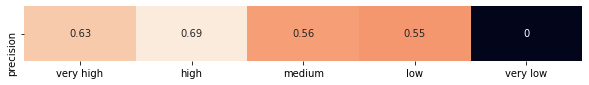

In [315]:
y_pred=np.argmax( model.predict(X_test) , axis=1 )

prec = precision_score(np.argmax(Y_test,axis=1),y_pred,average= None,zero_division=False)
df_cm = pd.DataFrame(prec.reshape(1,-1), columns = [key for key in dic_classification.keys()],
                  index = ['precision'])
plt.figure(figsize = (10,1))
sns.heatmap(df_cm, annot=True,cbar=0)
#plt.savefig('prec-early-best.pdf',bbox_inches='tight')

fine tuning the hyperparameters using kerastuner

In [198]:
import kerastuner as kt

def model_builder(hp):
    model = Sequential()
    #model.add(ks.layers.Flatten(input_shape=(1,11)))

    hp_units = hp.Int('units1', min_value=5, max_value=100, step=5)
    model.add(ks.layers.Dense(units=hp_units, input_dim=np.shape(X)[1],
                               activation='relu', 
                               kernel_regularizer=ks.regularizers.l2(.05)))

    
    hp_units2 = hp.Int('units2', min_value=5, max_value=100, step=5)
    model.add(Dense(units=hp_units2, activation='tanh',kernel_regularizer=ks.regularizers.l2(.05)))
    
    
    model.add(Dense(len(set(Y)), activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=ks.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [199]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=os.path.normpath('C:/'),
                     project_name='nn_class_v3_gross_based-early')

In [200]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [201]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and for second layers is {best_hps.get('units2')}  and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.5877934098243713

Best val_accuracy So Far: 0.6187793612480164
Total elapsed time: 00h 01m 12s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 30 and for second layers is 40  and the optimal learning rate for the optimizer
is 0.01.



In [202]:
%%time
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=200, validation_split=0.2,verbose=0)



Wall time: 29.2 s


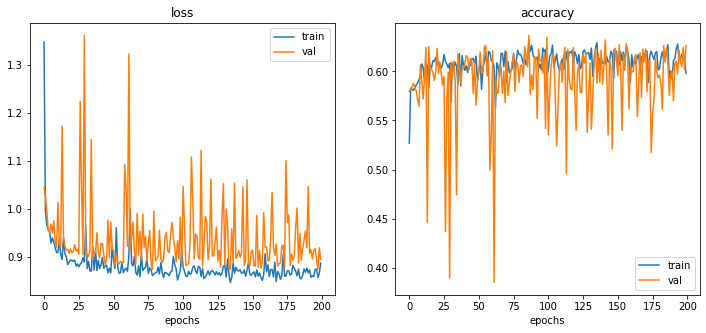

In [206]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])

ax[0].legend(['train','val'])
ax[1].legend(['train','val'])

ax[0].set_title('loss')
ax[1].set_title('accuracy')

ax[0].set_xlabel('epochs')
ax[1].set_xlabel('epochs')
plt.savefig('val-acc-world-early.pdf')
plt.show()

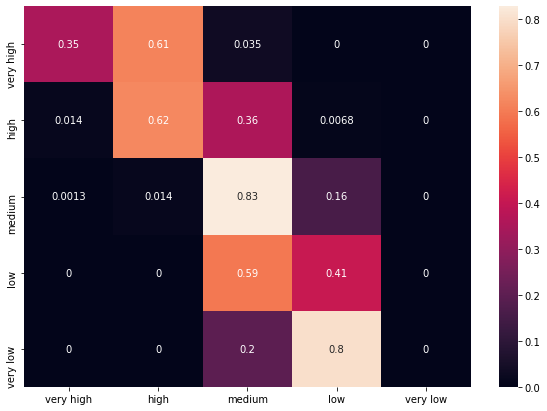

In [207]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(np.argmax( Y_test , axis=1 ), Y_predicted)
vector = cm.sum(axis=1)

cm = cm / vector[:,None]
df_cm = pd.DataFrame(cm, index = [key for key in dic_classification.keys()],
                  columns = [key for key in dic_classification.keys()])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('early-class-early.pdf',bbox_inches='tight')
plt.show()

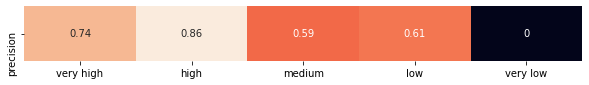

In [208]:
y_pred=np.argmax( model.predict(X_test) , axis=1 )

prec = precision_score(np.argmax(Y_test,axis=1),y_pred,average= None,zero_division=False)
df_cm = pd.DataFrame(prec.reshape(1,-1), columns = [key for key in dic_classification.keys()],
                  index = ['precision'])
plt.figure(figsize = (10,1))
sns.heatmap(df_cm, annot=True,cbar=0)
plt.savefig('prec-early.pdf',bbox_inches='tight')

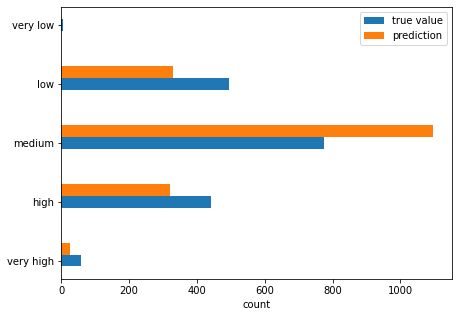

In [229]:
plt.figure(figsize=(7,5))
uni,count = np.unique(np.argmax(Y_test,axis=1),return_counts=1)
uni2,count2 = np.unique(np.argmax(model.predict(X_test),axis=1),return_counts=1)

plt.barh(list(label.keys()),count,height=0.2,label='true value')
plt.barh(uni2+0.2,count2,height=0.2,label='prediction')
plt.xlabel('count')
plt.savefig('bar-test-pred-early.pdf',bbox_inches='tight')
plt.legend()

## Early regressio problem 

In this section we solve the problem like the previous section but for regression. 

In [230]:
df=pd.read_csv('final v3.csv')
df.drop('IMDB ID',inplace=True,axis=1)
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=5,weights='distance')
df=pd.DataFrame(imp.fit_transform(df),index=df.index , columns=df.columns)

df=df.drop(['additive Producer(s) rank',
'additive Director(s) rank',
'additive Writer(s) rank',
'additive Stars rank',
'additive Distributor rank','IMDB score','IMDB votes',
'Mojo ID','In Realease (Days)',
'Widest Release','Metascore','User',
'Critic','Year'],axis=1)


X=df.drop(['Domestic Gross ($)','Worldwide Gross ($)'],axis=1).to_numpy()
Y=df['Domestic Gross ($)'].to_numpy()
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X,Y=shuffle(X,Y)


In [231]:
df

,Opening ($),Budget,Opening Theaters,Running time (min),genre Action,genre Adventure,genre Fantasy,genre Sci-Fi,genre Animation,genre Comedy,...,country Swaziland,country Republic of North Macedonia,country Reunion,Producer(s) rank,Director(s) rank,Writer(s) rank,Stars rank,Distributor rank,Domestic Gross ($),Worldwide Gross ($)
0,77025481.0,2.370000e+08,3452.0,162.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,749766139.0,2.744337e+09
1,110307189.0,2.000000e+08,4028.0,103.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,415004880.0,1.066970e+09
2,116101023.0,2.000000e+08,3728.0,108.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334191110.0,1.025467e+09
3,128122480.0,2.000000e+08,4380.0,124.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,312433331.0,6.239333e+08
4,64832191.0,6.800000e+07,4468.0,124.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300531751.0,6.984913e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7091,1273.0,5.591229e+07,1.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1273.0,1.273000e+03
7092,546.0,5.134240e+07,1.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4140.0,4.140000e+03
7093,790.0,2.970658e+07,1.0,104.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,790.0,7.900000e+02
7094,348.0,8.025029e+06,1.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1737.0,7.086596e+06


In [252]:
Y_log=np.log10(df['Domestic Gross ($)'])

In [253]:
X=df.drop(['Domestic Gross ($)','Worldwide Gross ($)'],axis=1).to_numpy()
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X,Y=shuffle(X,Y_log)

In [255]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

In [270]:
import kerastuner as kt

def model_builder(hp):
    model = Sequential()
    #model.add(ks.layers.Flatten(input_shape=(1,11)))

    hp_units = hp.Int('units1', min_value=5, max_value=100, step=5)
    model.add(ks.layers.Dense(units=hp_units, input_dim=np.shape(X)[1],
                               activation='relu', 
                               kernel_regularizer=ks.regularizers.l2(.05)))

    
    hp_units2 = hp.Int('units2', min_value=5, max_value=100, step=5)
    model.add(Dense(units=hp_units2, activation='relu',kernel_regularizer=ks.regularizers.l2(.05)))
    
    
    model.add(Dense(1, activation='linear'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=ks.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])

    return model

In [271]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mse',
                     max_epochs=10,
                     factor=3,
                     directory=os.path.normpath('C:/'),
                     project_name='nn_reg_v3_gross_based-early')

In [272]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and for second layers is {best_hps.get('units2')}  and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 03s]
val_mse: 1.297433614730835

Best val_mse So Far: 0.7381373047828674
Total elapsed time: 00h 01m 25s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 70 and for second layers is 90  and the optimal learning rate for the optimizer
is 0.01.



In [273]:
%%time
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=200, validation_split=0.2,verbose=0)



Wall time: 31.5 s


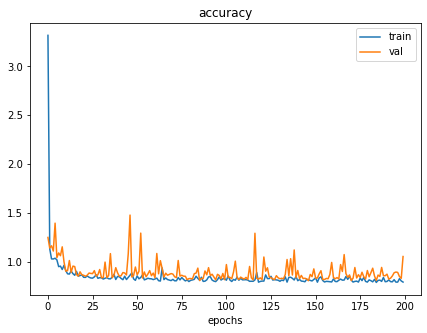

In [274]:
fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])

ax.legend(['train','val'])

ax.set_title('accuracy')

ax.set_xlabel('epochs')

#plt.savefig('val-acc-world-early-reg.pdf')
plt.show()

In [276]:
r2_score(Y_train,model.predict(X_train))

0.5158304398164315

In [279]:
model = Sequential()
model.add(ks.layers.Dense(20, input_dim=np.shape(X)[1],activation='relu', kernel_regularizer=ks.regularizers.l2(.05)))
model.add(Dense(units=16, activation='relu',kernel_regularizer=ks.regularizers.l2(.05)))
model.add(Dense(1, activation='linear'))
model.summary()
model.compile(optimizer=ks.optimizers.Adam(learning_rate=0.01),loss='mse',metrics=['mse'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                5540      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 5,893
Trainable params: 5,893
Non-trainable params: 0
_________________________________________________________________


In [280]:
history = model.fit(X_train, Y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

Epoch 1/150
86/86 [==============================] - 1s 6ms/step - loss: 10.3403 - mse: 8.9101 - val_loss: 1.6209 - val_mse: 0.9948
Epoch 2/150
86/86 [==============================] - 0s 2ms/step - loss: 1.5148 - mse: 0.9126 - val_loss: 1.2934 - val_mse: 0.8278
Epoch 3/150
86/86 [==============================] - 0s 2ms/step - loss: 1.2182 - mse: 0.7823 - val_loss: 1.1275 - val_mse: 0.7595
Epoch 4/150
86/86 [==============================] - 0s 1ms/step - loss: 1.0648 - mse: 0.7191 - val_loss: 1.0659 - val_mse: 0.7664
Epoch 5/150
86/86 [==============================] - 0s 2ms/step - loss: 1.0186 - mse: 0.7283 - val_loss: 1.0713 - val_mse: 0.8037
Epoch 6/150
86/86 [==============================] - 0s 1ms/step - loss: 1.0178 - mse: 0.7660 - val_loss: 1.0454 - val_mse: 0.7936
Epoch 7/150
86/86 [==============================] - 0s 2ms/step - loss: 0.9880 - mse: 0.7446 - val_loss: 1.0002 - val_mse: 0.7657
Epoch 8/150
86/86 [==============================] - 0s 1ms/step - loss: 0.9825 - 

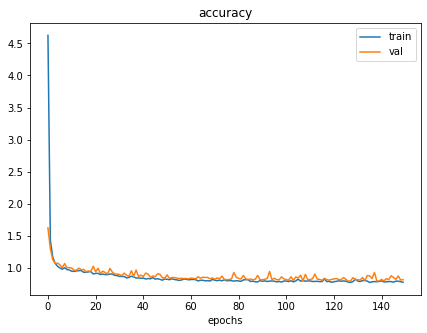

In [284]:
fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])

ax.legend(['train','val'])

ax.set_title('accuracy')

ax.set_xlabel('epochs')

plt.savefig('val-acc-dom-early-reg.pdf')
plt.show()

In [283]:
r2_score(Y_test,model.predict(X_test))

0.6276036529062268